# Scum Detection

In [1]:
import pandas as pd
from category_encoders import TargetEncoder
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

# Dataset Review

In [2]:
df_train = pd.read_csv("train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44279 entries, 0 to 44278
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   44279 non-null  int64  
 1   profile      44279 non-null  object 
 2   location     44279 non-null  object 
 3   score        44279 non-null  float64
 4   reviews      44279 non-null  int64  
 5   counted      44279 non-null  int64  
 6   item_id      44279 non-null  int64  
 7   item_name    44279 non-null  object 
 8   price        44279 non-null  int64  
 9   category_id  44279 non-null  int64  
 10  status       44279 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 3.7+ MB


In [3]:
df_test = pd.read_csv("test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8533 entries, 0 to 8532
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   8533 non-null   int64  
 1   profile      8533 non-null   object 
 2   location     8533 non-null   object 
 3   score        8533 non-null   float64
 4   reviews      8533 non-null   int64  
 5   counted      8533 non-null   int64  
 6   item_id      8533 non-null   int64  
 7   item_name    8533 non-null   object 
 8   price        8533 non-null   int64  
 9   category_id  8533 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 666.8+ KB


In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,44279.0,1.611915e+04,1.176501e+04,0.0,5.975500e+03,1.226700e+04,2.659850e+04,3.999900e+04
score,44279.0,4.826798e+00,5.620523e-01,0.0,4.800000e+00,5.000000e+00,5.000000e+00,5.000000e+00
reviews,44279.0,9.997425e+01,1.484333e+02,1.0,1.100000e+01,3.300000e+01,1.250000e+02,5.620000e+02
counted,44279.0,9.334574e+01,1.419835e+02,0.0,1.100000e+01,3.300000e+01,1.080000e+02,5.580000e+02
item_id,44279.0,2.301925e+12,4.227050e+11,146981994.0,2.115774e+12,2.346769e+12,2.594188e+12,3.138400e+12
price,44279.0,1.860055e+05,2.614603e+07,0.0,9.000000e+02,3.690000e+03,9.000000e+03,4.900089e+09
category_id,44279.0,4.806039e+01,3.252621e+01,0.0,2.100000e+01,3.200000e+01,8.400000e+01,1.160000e+02
status,44279.0,2.301091e-01,4.209072e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [5]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,8533.0,1.972428e+04,1.125131e+04,2.938000e+03,1.079400e+04,1.639300e+04,2.818700e+04,3.994600e+04
score,8533.0,4.491445e+00,6.401015e-01,0.000000e+00,4.300000e+00,4.300000e+00,5.000000e+00,5.000000e+00
reviews,8533.0,1.504957e+01,9.391234e+00,1.000000e+00,7.000000e+00,1.500000e+01,2.400000e+01,3.800000e+01
counted,8533.0,1.295582e+01,8.452512e+00,0.000000e+00,7.000000e+00,1.200000e+01,2.100000e+01,3.800000e+01
item_id,8533.0,2.433277e+12,2.687036e+11,1.669793e+11,2.383285e+12,2.439902e+12,2.599356e+12,3.106518e+12
price,8533.0,3.324093e+04,3.867652e+05,0.000000e+00,4.000000e+03,1.050000e+04,1.450000e+04,1.500350e+07
category_id,8533.0,3.752736e+01,2.127427e+01,0.000000e+00,2.700000e+01,3.400000e+01,3.800000e+01,1.050000e+02


In [6]:
df_train.head()

,Unnamed: 0,profile,location,score,reviews,counted,item_id,item_name,price,category_id,status
0,0,user_544,location_60,5.0,3,3,2602820915448,Фреон/Хладон R-404A (баллон 109 кг),4900,21,0
1,1,user_307,location_214,5.0,18,17,2552000920485,Кроссовки Adidas Yeezy Boost 700 Wave Runner,4300,27,0
2,2,user_307,location_214,5.0,18,17,2327236786910,AirPods Pro Оригинал,6600,32,0
3,3,user_307,location_214,5.0,18,17,2359571976563,Часы Casio оригинал,600,28,0
4,4,user_307,location_214,5.0,18,17,2519449598961,AirPods Pro,980,32,0


In [7]:
df_test.head()

,Unnamed: 0,profile,location,score,reviews,counted,item_id,item_name,price,category_id
0,2938,user_153,location_202,5.0,12,11,1839944715700,Автономный отопитель дизельный,10490,21
1,2939,user_153,location_40,5.0,12,11,2223990345525,Гарри Поттер Росмэн 7 книг,5000,83
2,2940,user_153,location_40,5.0,12,11,2223954634424,Гарри Поттер от Росмэн,5000,83
3,2941,user_153,location_40,5.0,12,11,2223621240803,Гарри Поттер 7 книг,5000,83
4,2942,user_153,location_40,5.0,12,11,1903333326923,Гарри Поттер Росмэн,4990,83


In [8]:
df_train = df_train.drop(columns=["Unnamed: 0", "item_id", "category_id"])
y_train = df_train['status']
df_train = df_train.drop(columns=['status'])

df_test = df_test.drop(columns=["Unnamed: 0", "item_id", "category_id"])
user_profile = df_test['profile']

Кодировка категориальных признаков

In [9]:
target_encoder = TargetEncoder()
df_train = target_encoder.fit_transform(df_train, y_train)
df_test = target_encoder.transform(df_test)

Пропуски в датасетах

<Axes: >

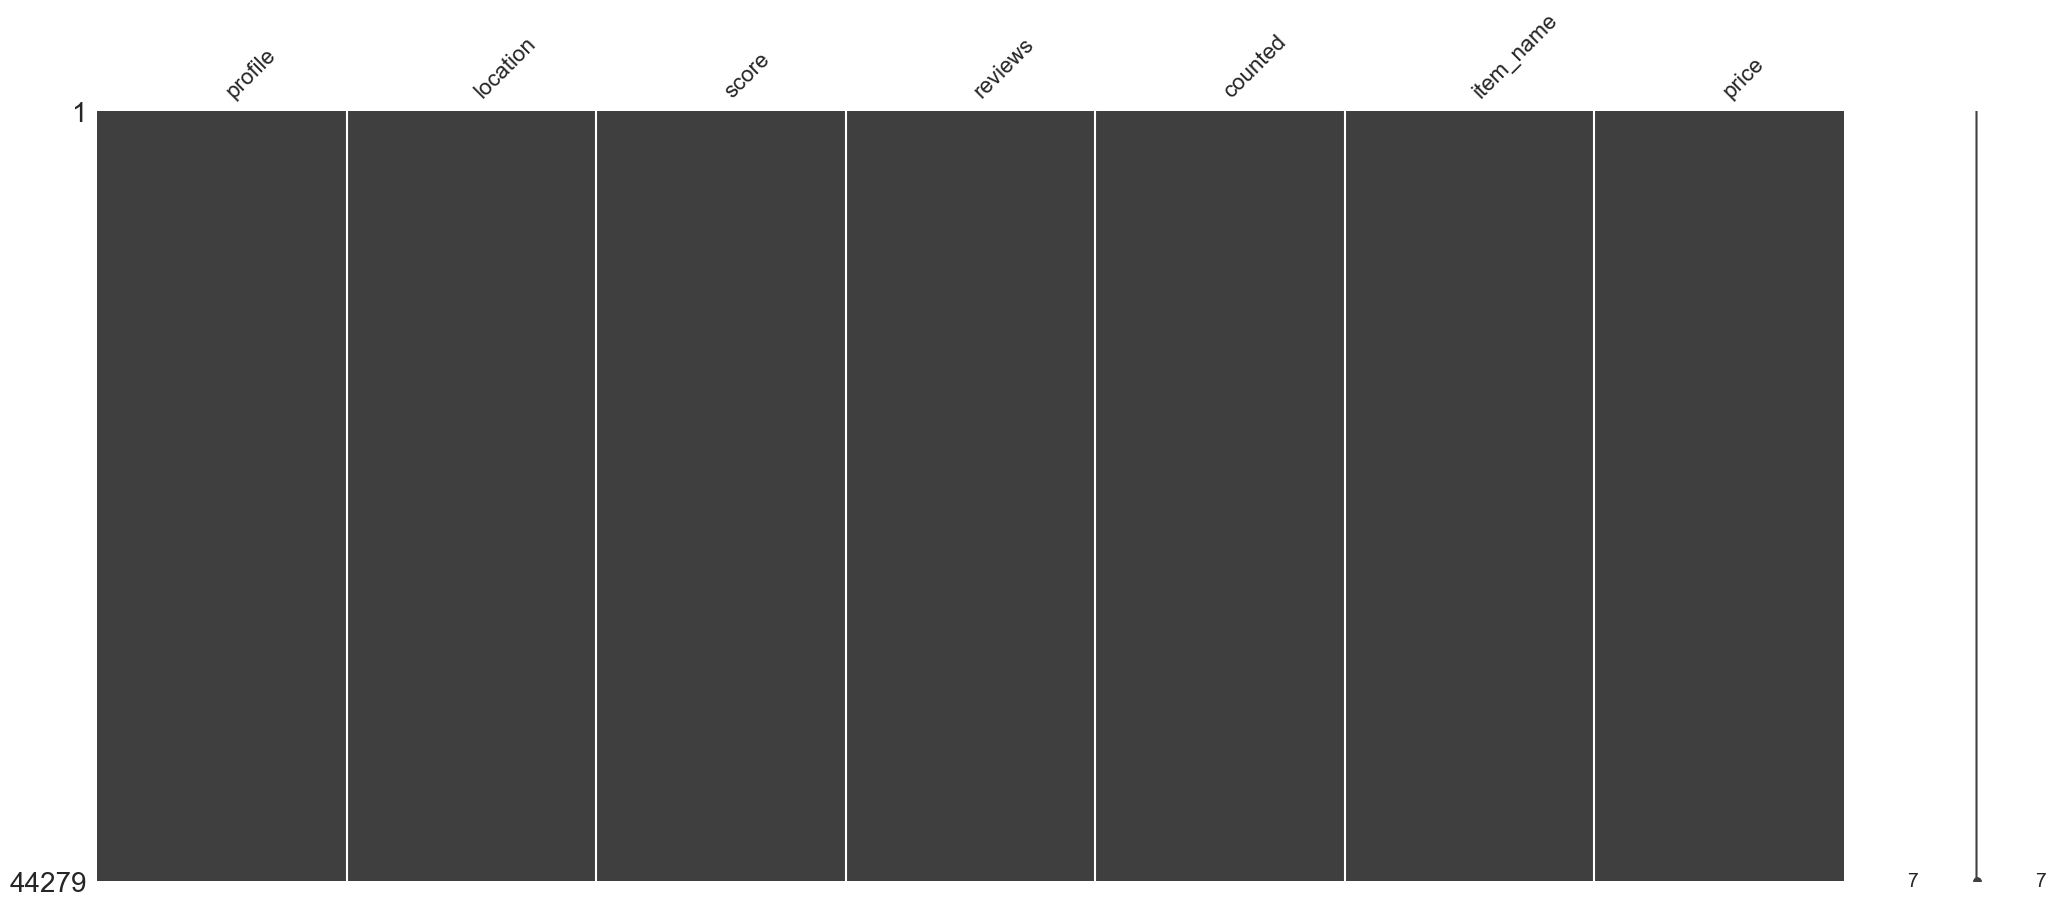

In [10]:
msno.matrix(df_train)

<Axes: >

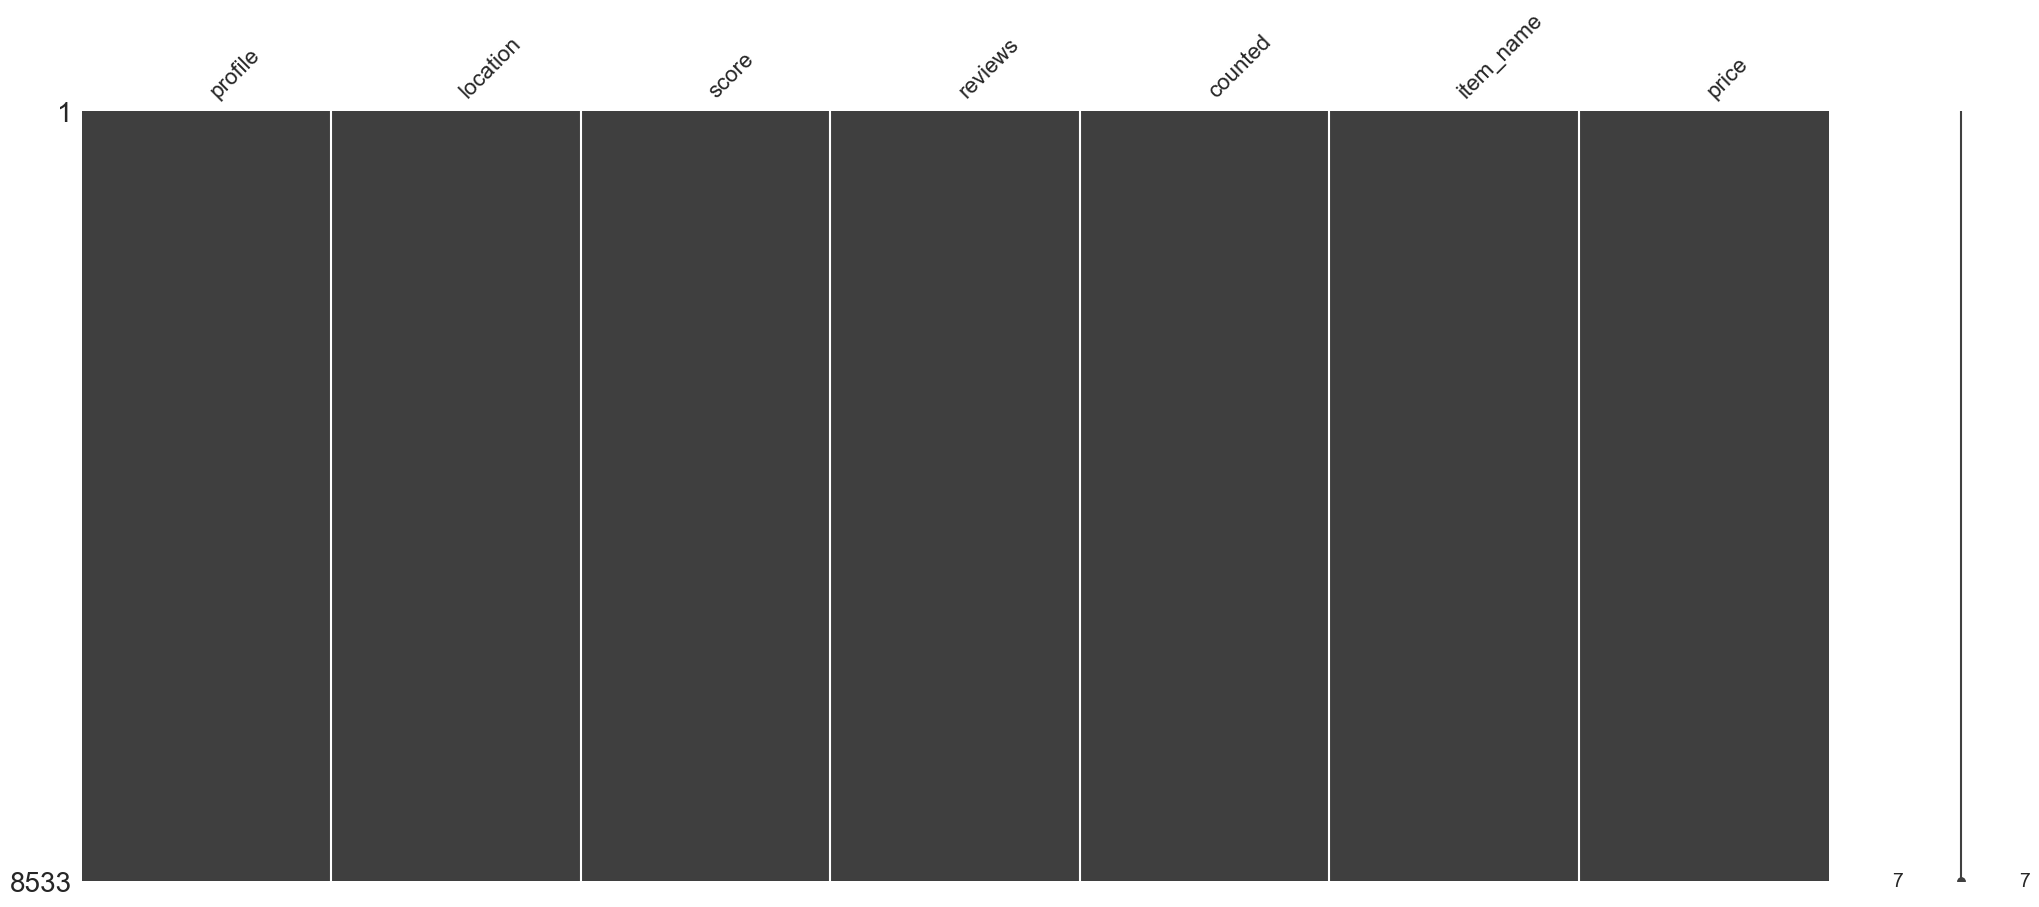

In [11]:
msno.matrix(df_test)

Выбросы в датасетах

In [12]:
binary_train_columns = df_train.columns[df_train.isin([0, 1]).all()]
binary_test_columns = df_test.columns[df_test.isin([0, 1]).all()]

df_check_train = df_train.drop(columns=binary_train_columns)
df_check_test = df_test.drop(columns=binary_test_columns)

Q1 = df_check_train.quantile(0.25)
Q3 = df_check_train.quantile(0.75)

df_train = df_train.drop(columns=df_check_train)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

column_to_check = df_check_train[(df_check_train >= lower_bound) & (df_check_train <= upper_bound)]
df_train = pd.concat([column_to_check, df_train], axis=1)

Q1 = df_check_test.quantile(0.25)
Q3 = df_check_test.quantile(0.75)

df_test = df_test.drop(columns=df_check_test)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

column_to_check = df_check_test[(df_check_test >= lower_bound) & (df_check_test <= upper_bound)]
df_test = pd.concat([column_to_check, df_test], axis=1)

Избавимся от пропусков

In [13]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_train)
df_train = pd.DataFrame(normalized_data, columns=df_train.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df_train)
df_filled_original = scaler.inverse_transform(df_filled)
df_train = pd.DataFrame(df_filled_original, columns=df_train.columns)

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_test)
df_test = pd.DataFrame(normalized_data, columns=df_test.columns)


imputer = KNNImputer()
df_filled = imputer.fit_transform(df_test)
df_filled_original = scaler.inverse_transform(df_filled)
df_test = pd.DataFrame(df_filled_original, columns=df_test.columns)

Выполним нормализацию и стандартизацию данных

In [14]:
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

print(type(df_train))
normalized_data = minmax_scaler.fit_transform(df_train)
df_train = pd.DataFrame(normalized_data, columns=df_train.columns)

standard_data = standard_scaler.fit_transform(df_train)
df_train = pd.DataFrame(standard_data, columns=df_train.columns)

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

normalized_data = minmax_scaler.fit_transform(df_test)
df_test = pd.DataFrame(normalized_data, columns=df_test.columns)

standard_data = standard_scaler.fit_transform(df_test)
df_test = pd.DataFrame(standard_data, columns=df_test.columns)
df_train.head()

<class 'pandas.core.frame.DataFrame'>


,profile,location,score,reviews,counted,item_name,price
0,-0.166065,1.402144,0.630214,-0.853029,-0.795963,0.505539,-0.019798
1,1.419764,-0.894127,0.630214,-0.596173,-0.568367,0.505539,-0.139530
2,1.419764,-0.894127,0.630214,-0.596173,-0.568367,0.426244,0.319442
3,1.419764,-0.894127,0.630214,-0.596173,-0.568367,0.505539,-0.877876
4,1.419764,-0.894127,0.630214,-0.596173,-0.568367,0.426244,-0.802046


Сэмплирование

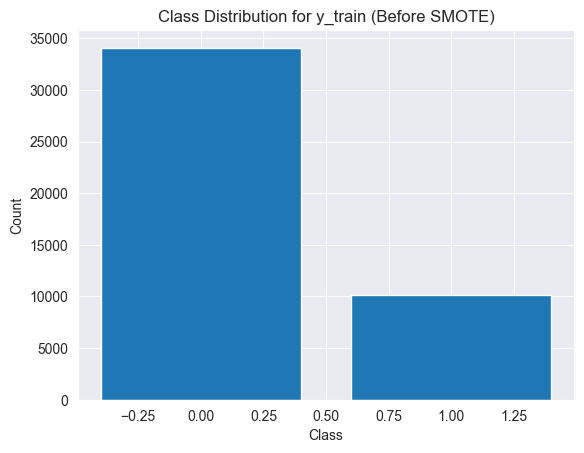

In [15]:
counter = Counter(y_train)
for k, v in counter.items():
    per = v / len(y_train) * 100
plt.bar(counter.keys(), counter.values())
plt.title("Class Distribution for y_train (Before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Apply SMOTE
smote = SMOTE()
df_train, y_train = smote.fit_resample(df_train, y_train)

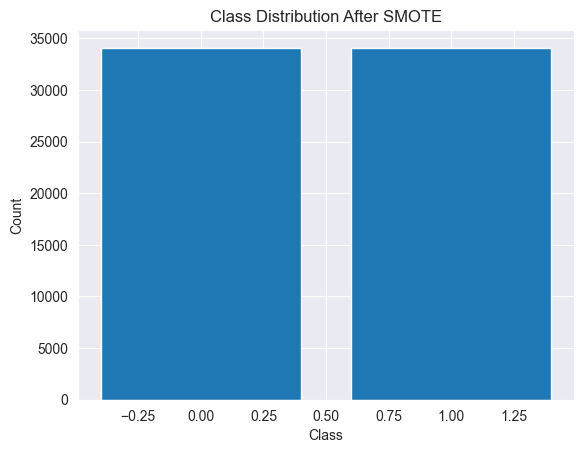

In [16]:
counter_resampled = Counter(y_train)
for k,v in counter_resampled.items():
    per = v / len(y_train) * 100
plt.bar(counter_resampled.keys(), counter_resampled.values())
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Обучение моделей

In [17]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.3)

KNN

In [22]:
# Модель k-ближайших соседей
knn_model = KNeighborsClassifier()

knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25]}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=stratified_kfold)
knn_grid_search.fit(X_train, Y_train)

best_knn_model = knn_grid_search.best_estimator_
Y_pred = best_knn_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9875818910726508


Логистическая регрессия

In [19]:
logreg_model = LogisticRegression(max_iter=1000)

logreg_param_grid = {'C': [0.1, 1, 10], 'solver': ['saga', 'sag']}
logreg_grid_search = GridSearchCV(logreg_model, logreg_param_grid, cv=stratified_kfold)
logreg_grid_search.fit(X_train, Y_train)

best_logreg_model = logreg_grid_search.best_estimator_
Y_pred = best_logreg_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8857925100224895


Decision Tree

In [20]:
decision_tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_tree = GridSearchCV(decision_tree, param_grid, cv=stratified_kfold)
grid_search_tree.fit(X_train, Y_train)

best_tree_model = grid_search_tree.best_estimator_
Y_pred = best_tree_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9920797887943679


AdaBoost

C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-pac

Accuracy: 0.9924220201427594
